### imports

In [1]:
import pyspark
import pyspark.sql.functions as F
from pyspark.sql.functions import *
from pyspark.sql.types import (
    StructType, StructField,
    StringType, LongType, DoubleType, TimestampType
)
import pandas as pd
import numpy as np
import os
import sys
import math
from pyspark.sql import SparkSession
from pyspark.context import SparkContext
import matplotlib.pyplot as plt
import pyarrow

## 1. Recommendation Engine with PySpark

In [2]:
# Inicializa a sessão Spark
spark = SparkSession.builder.appName("PMBD - Collaborative Filtering") \
    .config("spark.sql.shuffle.partitions", "400") \
    .config("spark.driver.maxResultSize", "4g") \
    .config("spark.sql.execution.arrow.enabled", "true") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.cores", "8") \
    .config("spark.executor.memoryOverhead", "4g") \
    .config("spark.executor.instances", "10") \
    .getOrCreate()

spark.sparkContext.setLogLevel("INFO")  # Pode ser ajustado para "INFO" durante o desenvolvimento

In [3]:
print(spark.sparkContext._jsc.sc().isStopped())  # False -> tudo bem; True -> Spark está desligado

False


In [4]:
data_dir = "../data/"

dataProcessed_dir = data_dir + "processed/"
dataRaw_dir = data_dir + "raw/"
# Criar diretórios se não existirem
os.makedirs(dataProcessed_dir, exist_ok=True)
os.makedirs(dataRaw_dir, exist_ok=True)


schema = StructType([
    StructField("event_time", TimestampType(), True),
    StructField("event_type", StringType(), True),
    StructField("product_id", LongType(), True),
    StructField("category_id", LongType(), True),
    StructField("category_code", StringType(), True),
    StructField("brand", StringType(), True),
    StructField("price", DoubleType(), True),
    StructField("user_id", LongType(), True),
    StructField("user_session", StringType(), True)
])

products = spark.read.parquet(dataProcessed_dir + 'products.parquet', schema=schema).limit(1000000)
user = spark.read.parquet(dataProcessed_dir + 'users.parquet', schema=schema).limit(1000000)
categories = spark.read.parquet(dataProcessed_dir + 'categories.parquet', schema=schema).limit(1000000)
df = spark.read.parquet(dataProcessed_dir + 'ec.parquet', schema=schema).limit(1000000)

In [5]:
df.printSchema()

root
 |-- product_id: integer (nullable = true)
 |-- event_time: timestamp (nullable = true)
 |-- event_type: string (nullable = true)
 |-- category_id: long (nullable = true)
 |-- category_code: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- price: double (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- user_session: string (nullable = true)
 |-- relative_price: double (nullable = true)



In [6]:
df.show(5, truncate=False)

+----------+-------------------+----------+-------------------+-----------------------------+-------+------+---------+------------------------------------+--------------------+
|product_id|event_time         |event_type|category_id        |category_code                |brand  |price |user_id  |user_session                        |relative_price      |
+----------+-------------------+----------+-------------------+-----------------------------+-------+------+---------+------------------------------------+--------------------+
|28715829  |2019-11-01 00:01:32|view      |2116907519078040377|apparel.shoes                |NULL   |62.81 |518621750|6d7138cd-b28a-4f0b-9238-ec30453316d7|-0.4565107245397681 |
|28718352  |2019-11-01 00:13:20|view      |2053013565639492569|apparel.shoes                |respect|84.43 |560601602|904572a9-9101-4ad4-b04d-6acc2ce4b9c0|-0.1568570600173971 |
|28715829  |2019-11-01 00:14:57|view      |2116907519078040377|apparel.shoes                |NULL   |62.81 |5601239

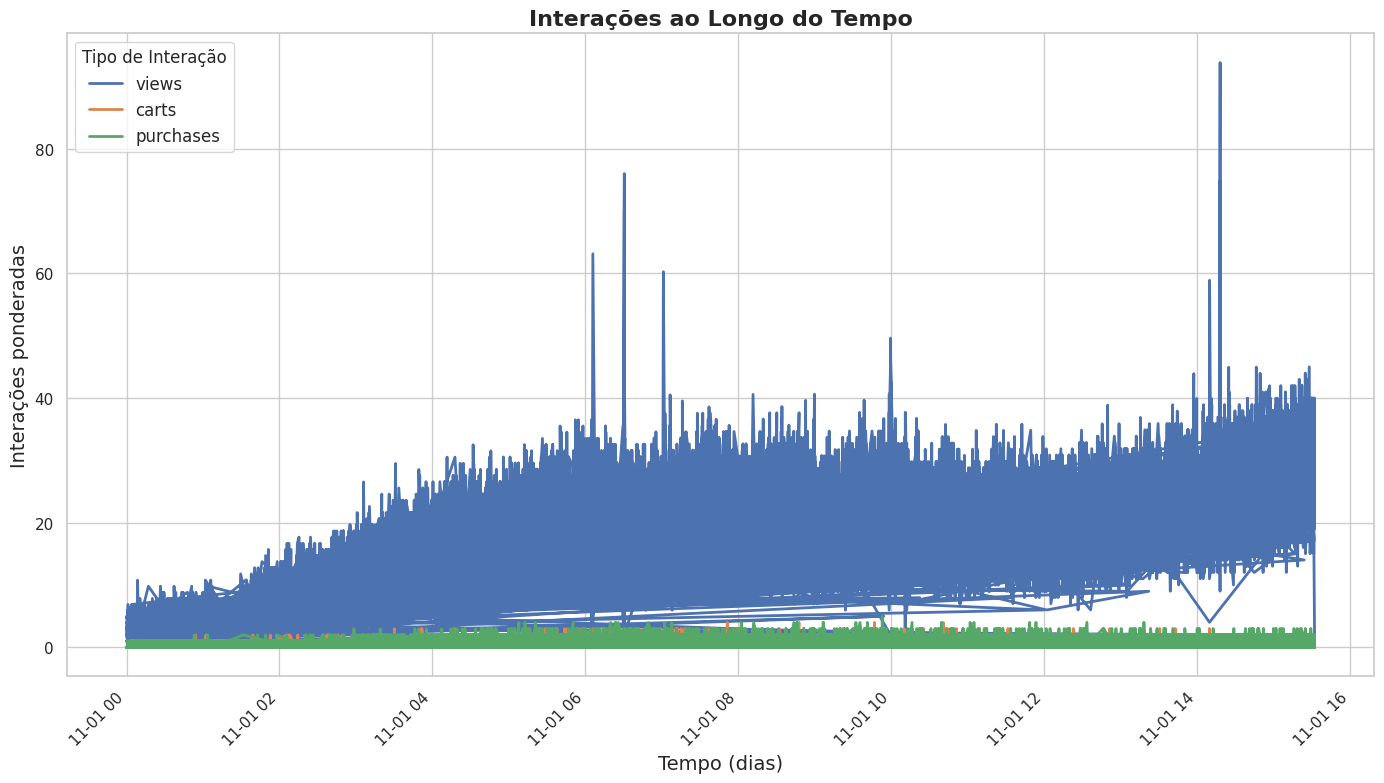

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import functions as F

# Estilo gráfico mais moderno e limpo
sns.set(style="whitegrid")

# Calcular a série temporal das interações
interaction_time_series = df.groupby('event_time').agg(
    F.sum(F.when(df['event_type'] == 'view', 1).otherwise(0) * df['recency_coef']).alias('views'),
    F.sum(F.when(df['event_type'] == 'cart', 1).otherwise(0) * df['recency_coef']).alias('carts'),
    F.sum(F.when(df['event_type'] == 'purchase', 1).otherwise(0) * df['recency_coef']).alias('purchases')
)

# Converter para Pandas
interaction_time_series_df = interaction_time_series.toPandas()

# Aumentar o tamanho da figura para lidar com muitos dados
plt.figure(figsize=(14, 8))

# Plotar o gráfico de linha
interaction_time_series_df.plot(x='event_time', y=['views', 'carts', 'purchases'], lw=2, ax=plt.gca())

# Título e rótulos com mais clareza
plt.title("Interações ao Longo do Tempo", fontsize=16, weight='bold')
plt.xlabel("Tempo (dias)", fontsize=14)
plt.ylabel("Interações ponderadas", fontsize=14)

# Melhorar a legibilidade dos rótulos do eixo X
plt.xticks(rotation=45, ha='right')

# Adicionar uma legenda
plt.legend(title="Tipo de Interação", fontsize=12)

# Ajuste do layout para não cortar elementos
plt.tight_layout()

# Mostrar o gráfico
plt.show()

## 2. Collaborative Filtering

A filtragem colaborativa permite recomendar produtos a utilizadores com base nas suas interações e nas de utilizadores semelhantes. O algoritmo **ALS (Alternating Least Squares)** aprende padrões entre utilizadores e produtos a partir da matriz de interações.

Para dar mais relevância às interações recentes, aplicamos uma **função de decaimento exponencial** com meia-vida de 20 dias. Assim, interações mais antigas têm menos peso, o que torna as recomendações mais atuais e personalizadas.

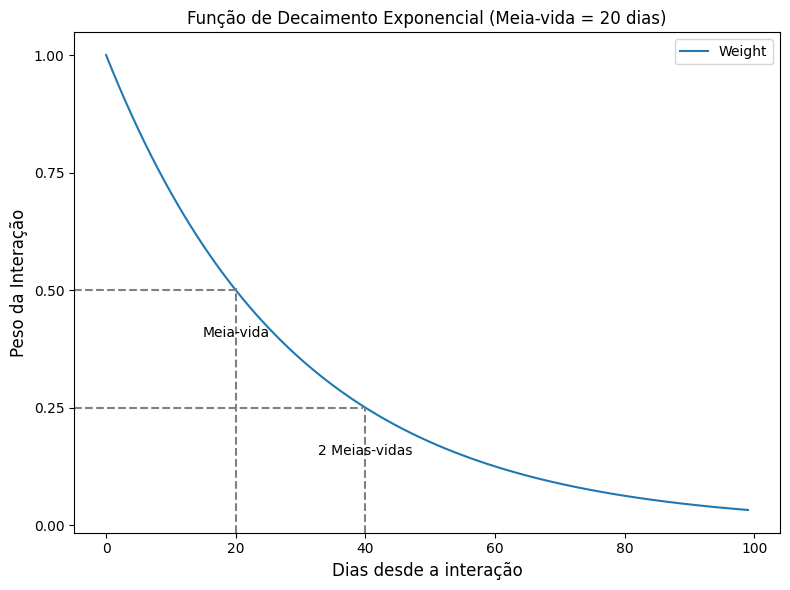

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

half_life = 20
x = np.arange(0, 100)
y = np.power(0.5, x / half_life)
df_halfLife = pd.DataFrame({'Days': x, 'Weight': y})

# Plot the function
ax = df_halfLife.plot(x='Days', y='Weight', title='Função de Decaimento Exponencial (Meia-vida = 20 dias)', figsize=(8, 6))

# Add vertical lines at 20 and 40 days with explanatory text
ax.axvline(x=20, linestyle='--', color='gray', ymax=0.49)
ax.axvline(x=40, linestyle='--', color='gray', ymax=0.25)
ax.axhline(y=0.5, linestyle='--', color='gray', xmax=0.23)
ax.axhline(y=0.25, linestyle='--', color='gray', xmax=0.41)

# Add explanatory text
ax.text(20, 0.4, 'Meia-vida', ha='center', fontsize=10)
ax.text(40, 0.15, '2 Meias-vidas', ha='center', fontsize=10)

# Adjust labels
ax.set_xlabel('Dias desde a interação', fontsize=12)
ax.set_ylabel('Peso da Interação', fontsize=12)

# Set custom y-ticks for better readability
ax.set_yticks([0, 0.25, 0.5, 0.75, 1])

plt.tight_layout()
plt.show()

In [8]:
# Get the timestamp of the most recent event in the df
last_date = df.agg(max('event_time')).collect()[0][0]
df = df.withColumn('last_date', lit(last_date))

# Calculate the recency of each event in terms of days
df = df.withColumn('recency', (col('last_date').cast('double') - col('event_time').cast('double')) / 86400)
df = df.drop('last_date')

# Half-life decay function, the value of an event is halved after 20 days
df = df.withColumn('recency_coef', expr('exp(ln(0.5)*recency/20)'))

df.show(5, truncate=False)

+----------+-------------------+----------+-------------------+-----------------------------+-------+------+---------+------------------------------------+--------------------+------------------+------------------+
|product_id|event_time         |event_type|category_id        |category_code                |brand  |price |user_id  |user_session                        |relative_price      |recency           |recency_coef      |
+----------+-------------------+----------+-------------------+-----------------------------+-------+------+---------+------------------------------------+--------------------+------------------+------------------+
|28715829  |2019-11-01 00:01:32|view      |2116907519078040377|apparel.shoes                |NULL   |62.81 |518621750|6d7138cd-b28a-4f0b-9238-ec30453316d7|-0.4565107245397681 |0.6462731481481482|0.9778508550499707|
|28718352  |2019-11-01 00:13:20|view      |2053013565639492569|apparel.shoes                |respect|84.43 |560601602|904572a9-9101-4ad4-b04

In [9]:
# Find the number of views, carts and purchases for each user-product pair
interactions = df.groupby(['user_id', 'product_id']).agg(sum(when(df['event_type'] == 'view', 1) * df['recency_coef']).alias('views'),
                                                         sum(when(df['event_type'] == 'cart', 1) * df['recency_coef']).alias('carts'),
                                                         sum(when(df['event_type'] == 'purchase', 1) * df['recency_coef']).alias('purchases'))
interactions = interactions.na.fill(0)
interactions.show(5, truncate=False)

+---------+----------+------------------+-----+---------+
|user_id  |product_id|views             |carts|purchases|
+---------+----------+------------------+-----+---------+
|518621750|28715829  |0.9778508550499707|0.0  |0.0      |
|560601602|28718352  |0.978128601982502 |0.0  |0.0      |
|560123935|28715829  |0.9781666610255967|0.0  |0.0      |
|512452141|14701533  |1.9567316170595968|0.0  |0.0      |
|549757937|3601423   |0.9784311534181631|0.0  |0.0      |
+---------+----------+------------------+-----+---------+
only showing top 5 rows



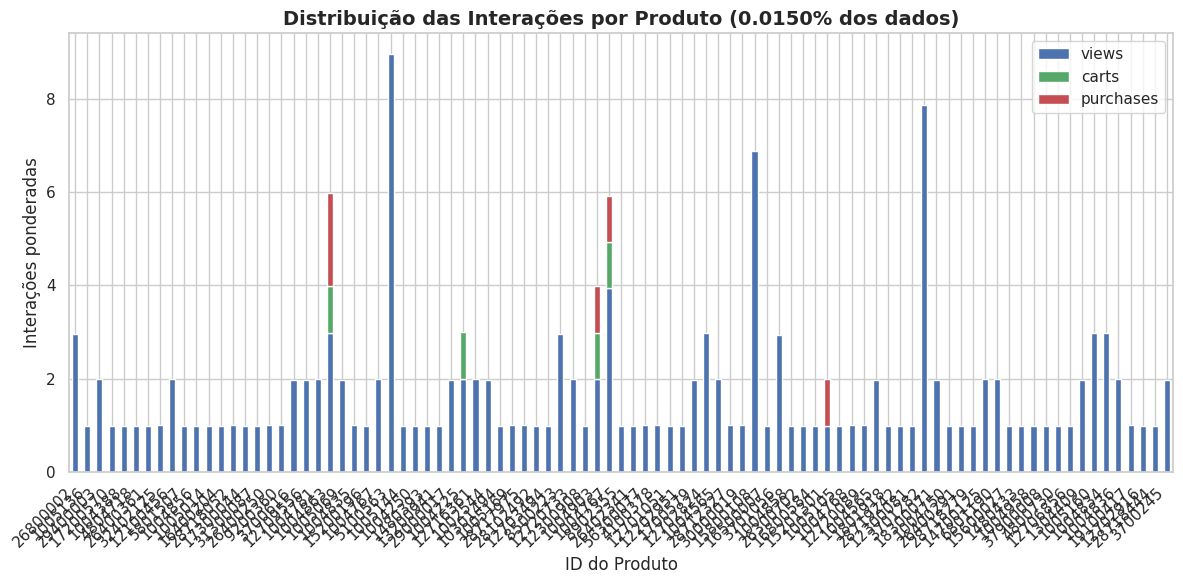

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Tamanho da amostra
frac = 0.00015

# Ordenar os dados no PySpark pela coluna 'purchases'
interactions_sorted = interactions.orderBy('purchases', ascending=False)

# Converter para Pandas e fazer a amostragem
interactions_df_sample = interactions_sorted.toPandas().sample(frac=frac, random_state=42)

# Estilo gráfico mais moderno e limpo
sns.set(style="whitegrid")

# Criar figura e eixos
fig, ax = plt.subplots(figsize=(12, 6))

# Plotar gráfico de barras empilhadas com as interações
interactions_df_sample.set_index('product_id')[['views', 'carts', 'purchases']].plot(
    kind='bar',
    stacked=True,
    ax=ax,
    color=['#4c72b0', '#55a868', '#c44e52']  # Paleta suave
)

# Título e rótulos
ax.set_title(f"Distribuição das Interações por Produto ({frac * 100:.4f}% dos dados)", fontsize=14, weight='bold')
ax.set_xlabel("ID do Produto", fontsize=12)
ax.set_ylabel("Interações ponderadas", fontsize=12)

# Rodar os rótulos do eixo X para melhor leitura
plt.xticks(rotation=45, ha='right')

# Melhorar layout e remover margens desnecessárias
plt.tight_layout()

# Mostrar gráfico
plt.show()

A matriz de interações é construída atribuindo pesos a cada tipo de interação do utilizador. Estas interações são somadas, após serem ponderadas por uma **função de decaimento de meia-vida**, que valoriza eventos mais recentes.

O resultado é transformado com **logaritmo base 10** e limitado a um máximo de 100, para garantir escalabilidade, consistência e reduzir o impacto de outliers. A matriz final reflete a **força da relação** entre utilizadores e produtos.

In [11]:
def calculate_interaction_matrix(df, view_weight=0.1, cart_weight=0.3, purchase_weight=1.0):
 
    # Create a new column with the weighted interaction value
    df = df.withColumn('interaction', view_weight * col('views') + cart_weight * col('carts') + purchase_weight * col('purchases'))
    
    # Use log10 value for views, carts and purchases
    df = df.withColumn('interaction', log10(col('interaction') + 1))
    
    # Set the max possible value to 100 (log100 = 2)
    df = df.withColumn('interaction', when(col('interaction') > 2, 2).otherwise(col('interaction')))

    return df

In [12]:
interaction_matrix = calculate_interaction_matrix(interactions)
interaction_matrix.show(5, truncate=False)

+---------+----------+------------------+-----+---------+--------------------+
|user_id  |product_id|views             |carts|purchases|interaction         |
+---------+----------+------------------+-----+---------+--------------------+
|518621750|28715829  |0.9778508550499707|0.0  |0.0      |0.040517326166055176|
|560601602|28718352  |0.978128601982502 |0.0  |0.0      |0.04052831396647704 |
|560123935|28715829  |0.9781666610255967|0.0  |0.0      |0.04052981957862195 |
|512452141|14701533  |1.9567316170595968|0.0  |0.0      |0.07761248110216143 |
|549757937|3601423   |0.9784311534181631|0.0  |0.0      |0.040540282728475395|
+---------+----------+------------------+-----+---------+--------------------+
only showing top 5 rows



In [13]:
#  User-product pairs with the highest interaction scores
interaction_matrix.sort('interaction', ascending=False).show()

+---------+----------+------------------+------------------+------------------+------------------+
|  user_id|product_id|             views|             carts|         purchases|       interaction|
+---------+----------+------------------+------------------+------------------+------------------+
|526933626|   1004833|23.711964421810254| 3.962223149519506|16.790713403664977|1.3294096120840113|
|515934670|   1005129|27.635904511648025|11.844995919277464|13.822171986857173|1.3250898052810447|
|514544847|  12700930|30.586231311421514| 1.971198363739571|13.818435294592774| 1.266429693946483|
|544048413|  27400000|27.676927691834017|               0.0|12.858257521796483|1.2207864776944806|
|551801600|   1003306|22.807199675580765|3.9596176295905137|11.911407754350048|1.2143142423883806|
|515676312|   1002544|23.943690150800364|1.9944037194629876|  11.9724723744105|1.2031733434710583|
|529831093|   6000227|19.693721716006056| 6.895137491629869|  9.84775084573469|1.1727682195746698|
|562363949

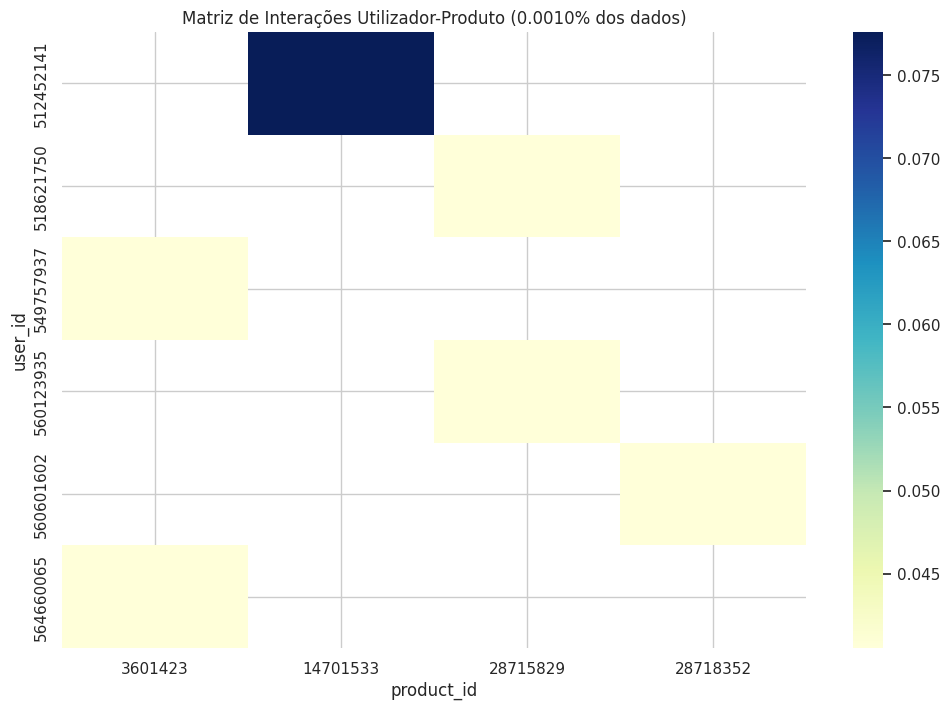

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# Tamanho da amostra
frac = 0.00001

# Calcular o número de amostras
sample_size = int(interaction_matrix.count() * frac)

# Amostragem dos dados
interaction_matrix_sample = interaction_matrix.limit(sample_size)

# Converter para Pandas
interaction_matrix_df = interaction_matrix_sample.toPandas()

# Gerar a matriz de interações utilizando o pivot
interaction_matrix_pivot = interaction_matrix_df.pivot(index='user_id', columns='product_id', values='interaction')

# Gerar a visualização
plt.figure(figsize=(12, 8))
sns.heatmap(interaction_matrix_pivot, cmap='YlGnBu')

# Título e mostrar o gráfico
plt.title(f"Matriz de Interações Utilizador-Produto ({frac * 100:.4f}% dos dados)")
plt.show()

Depois de criar uma matriz de interações ponderada entre utilizadores e produtos, esta pode ser usada pelo algoritmo **ALS** para aprender fatores latentes de ambos. Estes fatores permitem gerar **recomendações personalizadas**.

Depois de identificar o melhor conjunto de parâmetros, podemos treinar diretamente o modelo **ALS** sem recorrer novamente à validação cruzada. Esta abordagem é **mais eficiente**, poupando tempo e recursos ao gerar recomendações de produtos.

In [15]:
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator

def simple_als(interaction_matrix):
    
    # Train-test split
    (train, test) = interaction_matrix.randomSplit([0.8, 0.2])
    
    # Initialize the model with the optimized parameters
    als = ALS(userCol='user_id', itemCol='product_id', ratingCol='interaction', 
              alpha=1, regParam=0.005, rank=15, implicitPrefs=True, 
              nonnegative=True, coldStartStrategy='drop')

    # Fit the ALS model on the ratings data
    model = als.fit(train)
    
    # Make predictions
    predictions = model.transform(test)
    
    # Calculate the RMSE and MAE metrics
    evaluator = RegressionEvaluator(metricName='rmse', labelCol='interaction', predictionCol='prediction')
    rmse = evaluator.evaluate(predictions)
    mae = evaluator.setMetricName('mae').evaluate(predictions)
    print('test rmse:' + str(rmse) + ' mae:' + str(mae))
    
    return model

In [16]:
als_model = simple_als(interaction_matrix)
print(als_model.explainParams())

test rmse:0.09373480232983389 mae:0.06759189793453212
blockSize: block size for stacking input data in matrices. Data is stacked within partitions. If block size is more than remaining data in a partition then it is adjusted to the size of this data. (default: 4096)
coldStartStrategy: strategy for dealing with unknown or new users/items at prediction time. This may be useful in cross-validation or production scenarios, for handling user/item ids the model has not seen in the training data. Supported values: 'nan', 'drop'. (default: nan, current: drop)
itemCol: column name for item ids. Ids must be within the integer value range. (default: item, current: product_id)
predictionCol: prediction column name. (default: prediction)
userCol: column name for user ids. Ids must be within the integer value range. (default: user, current: user_id)


In [17]:
dir(als_model)

['__abstractmethods__',
 '__annotations__',
 '__class__',
 '__class_getitem__',
 '__del__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__orig_bases__',
 '__parameters__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_call_java',
 '_copyValues',
 '_copy_params',
 '_create_from_java_class',
 '_create_params_from_java',
 '_defaultParamMap',
 '_dummy',
 '_empty_java_param_map',
 '_from_java',
 '_is_protocol',
 '_java_obj',
 '_make_java_param_pair',
 '_new_java_array',
 '_new_java_obj',
 '_paramMap',
 '_params',
 '_randomUID',
 '_resetUid',
 '_resolveParam',
 '_set',
 '_setDefault',
 '_shouldOwn',
 '_testOwnParam',
 '_to_java',
 '_transfer_param_map_from_java',
 '_transfer_param_

In [18]:
als_model.userFactors.show(truncate=False)

+---------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|id       |features                                                                                                                                                                   |
+---------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|346791730|[0.0, 0.0, 0.0, 0.15579087, 0.0, 0.031180384, 0.0, 4.1075368E-4, 0.013542054, 0.036022738, 3.54637E-4, 0.0, 0.0, 0.0, 0.007997721]                                         |
|372804920|[0.0, 0.0012580279, 1.4687536E-4, 3.145116E-4, 1.7864387E-7, 3.9235328E-4, 0.0, 7.002245E-5, 2.8768149E-5, 3.531866E-4, 9.5536245E-4, 4.8060963E-4, 0.0, 1.4452265E-4, 0.0]|
|400680280|[0.0, 0.0011477093, 0.0, 0.002095968, 0.0, 5.1680807E-4, 0.0, 0.0, 1.

In [19]:
als_model.itemFactors.show(truncate=False)

+-------+------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|id     |features                                                                                                                                                          |
+-------+------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|1002100|[0.0026237525, 0.0069037583, 0.0016116332, 9.624042E-4, 1.5833064E-4, 3.5570317E-4, 0.008803627, 3.412887E-5, 0.0, 0.0034527564, 0.0, 0.0, 0.0015947015, 0.0, 0.0]|
|1002540|[0.0, 0.003393749, 0.03441862, 3.17554E-4, 0.0, 0.0025343825, 0.0031406144, 8.8763477E-7, 0.008077742, 0.0064263726, 2.3297174E-4, 3.5068562E-4, 0.0, 0.0, 0.0]   |
|1002550|[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]                                                   

### 2.1. Collaborative Filtering Item-Item

Quando um utilizador está a visualizar um produto específico, podemos melhorar a sua experiência de compra ao recomendar **produtos semelhantes**. Estas recomendações são focadas **no produto em si**, e não nas preferências individuais do utilizador.

Para tal, utilizamos o algoritmo **ALS**, que calcula fatores latentes dos produtos com base nas interações. Estes fatores refletem características intrínsecas dos produtos, permitindo compreender as suas **semelhanças subjacentes**.

Convertendo estes fatores em **vetores num espaço multidimensional**, aplicamos o algoritmo **Locality-Sensitive Hashing (LSH)** para identificar, de forma eficiente, vetores próximos — ou seja, produtos com **características semelhantes**.

Desta forma, conseguimos recomendar produtos que partilham atributos relevantes, sejam **alternativas dentro da mesma categoria** ou **itens complementares** de outras categorias.

Este tipo de recomendação ajuda os utilizadores a descobrir **novas opções relevantes**, enriquecendo a sua experiência e aumentando a diversidade dos produtos apresentados.

In [20]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import Normalizer
from pyspark.ml.feature import SQLTransformer

# Get the product factors from the ALS model
product_vectors = als_model.itemFactors
product_vectors = product_vectors.rdd.map(lambda row: (row[0], Vectors.dense(row[1])))
product_vectors = product_vectors.toDF(['product_id', 'features'])

# Use VectorAssembler to convert the features column into a dense vector column
assembler = VectorAssembler(inputCols=['features'], outputCol='vector')
product_vectors = assembler.transform(product_vectors)

# Normalize the vectors
normalizer = Normalizer(inputCol='vector', outputCol='norm_vector')
product_vectors = normalizer.transform(product_vectors)
product_vectors.show(truncate=False)

+----------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|product_id|features                                                                                                                                                                                                                                  |vector                                        

In [ ]:
from pyspark.sql.functions import col

# Selecionar um 'product_id' aleatório do dataframe 'product_vectors'
random_product = product_vectors.select('product_id', 'norm_vector').orderBy(F.rand()).limit(1)

# Obter o 'product_id' e 'norm_vector' do produto selecionado
random_product_id = random_product.collect()[0]['product_id']
random_product_features = random_product.collect()[0]['norm_vector']

# Mostrar o 'product_id' e as suas características
print(f"ID do produto selecionado: {random_product_id}")
print(f"\n####### Características do produto #######")

# Agora, fazer o join com o dataframe 'products' para mostrar as outras características do produto
product_details = products.join(random_product, on='product_id', how='inner')
product_details.show(truncate=False)

ID do produto selecionado: 4600430

####### Características do produto #######
+----------+-------------------+-----------------------------+-----+-----+---------+-----------------+-------------------+-------------------+--------------------+--------------------+------------------+---------------------+--------------------------------------------------+
|product_id|category_id        |category_code                |views|carts|purchases|price            |first_date         |last_date          |purchase_per_view   |cart_per_view       |purchase_per_cart |relative_price       |norm_vector                                       |
+----------+-------------------+-----------------------------+-----+-----+---------+-----------------+-------------------+-------------------+--------------------+--------------------+------------------+---------------------+--------------------------------------------------+
|4600430   |2053013563944993659|appliances.kitchen.dishwasher|32   |0    |0        |450.89

In [45]:
products.show(5, truncate=False)

+-------------------+----------+--------------------------+-----+-----+---------+------------------+-------------------+-------------------+--------------------+--------------------+------------------+--------------------+
|category_id        |product_id|category_code             |views|carts|purchases|price             |first_date         |last_date          |purchase_per_view   |cart_per_view       |purchase_per_cart |relative_price      |
+-------------------+----------+--------------------------+-----+-----+---------+------------------+-------------------+-------------------+--------------------+--------------------+------------------+--------------------+
|2053013552226107603|8600234   |appliances.environment.fan|3    |0    |0        |233.81000000000003|2019-11-01 08:12:36|2019-11-01 15:22:13|0.018432388804052836|0.01505613227428985 |1.1911351784997994|3.3114956736712     |
|2053013552226107603|8600233   |appliances.environment.fan|3    |0    |0        |25.709999999999997|2019-11-

In [22]:
# Get the normalized vector representation of the selected product
product_vector = product_vectors.where(col('product_id') == random_product_id).select('norm_vector').collect()[0][0]
product_vector

SparseVector(15, {0: 0.3533, 3: 0.3335, 10: 0.1732, 12: 0.855, 14: 0.0539})

O algoritmo **LSH (Locality-Sensitive Hashing)** é uma técnica utilizada para **pesquisa aproximada dos vizinhos mais próximos** em espaços de alta dimensão, com grande eficiência computacional.

O LSH funciona projetando aleatoriamente os dados de alta dimensão para um **espaço de menor dimensão**, através de funções de hash. O seu princípio baseia-se no facto de que **itens semelhantes têm maior probabilidade de cair no mesmo balde (bucket)**, enquanto itens diferentes tendem a ser separados em baldes distintos. Esta estratégia permite **reduzir drasticamente o espaço de procura**, limitando a busca aos candidatos que partilham o mesmo balde.

Os principais parâmetros do LSH são:

- **`numHashTables`**: Define o número de tabelas de hash utilizadas. Um número mais elevado de tabelas **melhora a precisão** da pesquisa, mas também **aumenta o custo computacional**.
- **`bucketLength`**: Controla o tamanho dos baldes. Baldes mais pequenos oferecem **maior precisão**, mas exigem mais recursos de processamento.

O LSH é, assim, uma solução eficaz para encontrar rapidamente produtos semelhantes em sistemas de recomendação com **grandes volumes de dados** e elevada dimensionalidade.

In [23]:
from pyspark.ml.feature import BucketedRandomProjectionLSH

brp = BucketedRandomProjectionLSH(inputCol="norm_vector", outputCol="neighbors", numHashTables=5, bucketLength=0.1)
brp_model = brp.fit(product_vectors)
brp_model

BucketedRandomProjectionLSHModel: uid=BucketedRandomProjectionLSH_ff7349aba519, numHashTables=5

In [24]:
print(brp_model.explainParams())

bucketLength: the length of each hash bucket, a larger bucket lowers the false negative rate. (current: 0.1)
inputCol: input column name. (current: norm_vector)
numHashTables: number of hash tables, where increasing number of hash tables lowers the false negative rate, and decreasing it improves the running performance. (default: 1, current: 5)
outputCol: output column name. (default: BucketedRandomProjectionLSH_ff7349aba519__output, current: neighbors)


In [25]:
transformed = brp_model.transform(product_vectors)
transformed.show(truncate=False)

+----------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------------------------------+
|product_id|features                                                                                                                                                                                                                                  |vector

In [26]:
# Find the nearest neighbors of a specific product
query = product_vectors.filter(col('product_id') == random_product_id).select('norm_vector').first()[0]
neighbors = brp_model.approxNearestNeighbors(product_vectors, query, numNearestNeighbors=50)
neighbors.show(truncate=False)

+----------+------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------+--------------------------------------+--------------------+
|product_id|features                                                                                                                                              |vector                                                                                                                            |norm_vector                                                                                                              |neighbors                             |distCol             |
+----------+----------------------------------

In [27]:
# Print the most similar products, the first entry is the product itself
neighbors.select('product_id', 'distCol').show(truncate=False)

+----------+--------------------+
|product_id|distCol             |
+----------+--------------------+
|15400278  |0.0                 |
|15400242  |8.527151035190486E-9|
|15400184  |9.842327054132286E-9|
|15400008  |1.189372930953654E-8|
|15400133  |1.279013952013992E-8|
|15400081  |1.344874636565889E-8|
|15400221  |2.295044959967912E-8|
|15400244  |0.00191825033607151 |
|15400235  |0.002068729860150592|
|15400183  |0.002536672138119765|
|6800475   |0.005901788029853895|
|6800867   |0.006384085151079858|
|21408120  |0.007524129140698914|
|6801059   |0.007901020895524377|
|6800719   |0.008608630752670338|
|6302029   |0.00983685548418233 |
|36000008  |0.00983686457354922 |
|6800050   |0.009840206252508468|
|21409152  |0.010088703993329892|
|14500095  |0.011360211675640147|
+----------+--------------------+
only showing top 20 rows



Quando calculamos os **scores de recomendação para produtos**, utilizamos uma abordagem semelhante à usada nas recomendações para utilizadores. Medimos a **semelhança entre produtos** com base na **distância cosseno** e combinamos essa informação com outras características, como a **taxa de conversão** e o **preço relativo**.

A função funciona de forma similar ao processo de recomendação para utilizadores, mas com uma pequena diferença. Em vez de calcular os **hábitos de gasto dos utilizadores**, consideramos o **preço relativo** do produto que está a ser visualizado. Isso ajuda a encontrar produtos que apresentam **faixas de preço semelhantes**.

In [28]:
def calculate_recommendation_scores_for_products(recs, products, coef_distance_score=0.8, coef_conversion_rate=0.1, coef_relative_price=0.1, coef_spending_booster=0.05):
   
    recs = recs.join(products['product_id', 'purchase_per_view', 'relative_price'], on='product_id')
     
    # Scale distance of nearest neigbors in the unit vector space, ranges from 0 to sqrt(2)
    recs = recs.withColumn('distCol', (math.sqrt(2) - col('distCol')) / math.sqrt(2))
    
    # Scale purchase_per_view rate, ranges from 0 to 0.075
    recs = recs.withColumn('purchase_per_view', col('purchase_per_view') / 0.075)
    
    # Scale relative price value, ranges from -5 to 5
    recs = recs.withColumn('relative_price', (col('relative_price') + 5) / 10)
    
    # Find the relative price of the chosen product
    product_relative_price = recs.filter(col('distCol') == 1)['product_id', 'relative_price'].collect()[0][1]

    # Scale product's average relative price value, ranges from -5 to 5
    product_relative_price = (product_relative_price + 5) / 10
    

    # Calculate the recommendation scores
    recs = recs.withColumn('recommendation_score', ((recs['distCol'] * coef_distance_score) + (recs['purchase_per_view'] * coef_conversion_rate) - abs(product_relative_price + coef_spending_booster - recs['relative_price']) * coef_relative_price) / (coef_distance_score + coef_conversion_rate + coef_relative_price)) 

    # Remove the searched product from the recommendations
    recs = recs.filter(col('distCol') != 1)
    
    
    # Scale back distance of nearest neigbors in the unit vector space, ranges from 0 to sqrt(2)
    recs = recs.withColumn('distCol', math.sqrt(2) - col('distCol') * math.sqrt(2))
    
    # Scale back purchase_per_view rate, ranges from 0 to 0.075
    recs = recs.withColumn('purchase_per_view', col('purchase_per_view') * 0.075)
    
    # Scale back relative price value, ranges from -5 to 5
    recs = recs.withColumn('relative_price', col('relative_price') * 10 - 5)

    # Scale product's average relative price value, ranges from -5 to 5
    product_relative_price = product_relative_price * 10 - 5
    
    return recs

In [29]:
random_product

DataFrame[product_id: bigint]

In [30]:
recs_product = calculate_recommendation_scores_for_products(neighbors.select('product_id', 'distCol'), products)
recs_product.show(truncate=False)

+----------+---------------------+--------------------+---------------------+--------------------+
|product_id|distCol              |purchase_per_view   |relative_price       |recommendation_score|
+----------+---------------------+--------------------+---------------------+--------------------+
|18500075  |0.0178789821733909   |0.0151080364961617  |-0.2792655945580025  |0.7953322454264873  |
|18500065  |0.01706088481312995  |0.015031656129649254|-0.301287484360496   |0.7954729717926682  |
|10502335  |0.018521138805908333 |0.007723931347928351|-0.18791710572532505 |0.7860369981362866  |
|12718234  |0.014998716974894855 |0.02870568753948351 |1.0396305125148988   |0.8282807319310898  |
|12712086  |0.014998725851929962 |0.02870568753948351 |-0.06674612634088195 |0.8172169605209226  |
|12701663  |0.01499872540852576  |0.02870568753948351 |1.0223480333730635   |0.8281079023688893  |
|17301016  |0.017372891044971972 |0.01973766765173903 |0.17893544733861866  |0.8063733857612659  |
|17300845 

In [55]:
# Limitar as primeiras 10 linhas do DataFrame antes de aplicar a estilização
df_limited = df_pd.head(10)

# Aplicar a estilização ao DataFrame limitado
styled_df = (
    df_limited.style
    .set_caption("🎯 Recomendações de Produto com Base em Similaridade, Conversão e Preço Relativo")
    .background_gradient(cmap='Purples', subset=['distCol'])
    .background_gradient(cmap='Greens', subset=['purchase_per_view'])
    .background_gradient(cmap='Oranges', subset=['relative_price'])
    .background_gradient(cmap='Blues', subset=['recommendation_score'])
    .format(precision=2)
    .set_properties(**{
        'text-align': 'center',
        'font-family': 'Segoe UI',
        'font-size': '13px',
        'width': '140px'
    })
    .set_table_styles([ 
        {'selector': 'caption', 'props': [('color', '#222'), ('font-size', '15px'), ('text-align', 'center'), ('caption-side', 'top'), ('font-weight', 'bold')]},
        {'selector': 'th', 'props': [('background-color', '#fafafa'), ('text-align', 'center'), ('font-weight', 'bold')]},
    ])
)

# Renderizar o DataFrame estilizado
styled_df

,Ranking,product_id,distCol,purchase_per_view,relative_price,recommendation_score
0,🥇,12718234,0.01,0.03,1.04,0.83
1,🥈,12701663,0.01,0.03,1.02,0.83
2,🥉,15400242,0.00,0.02,1.15,0.82
3,,15400133,0.00,0.02,1.26,0.82
4,,15400184,0.00,0.02,1.04,0.82
5,,15400081,0.00,0.02,1.45,0.82
6,,12712086,0.01,0.03,-0.07,0.82
7,,15400221,0.00,0.02,0.75,0.82
8,,15400235,0.00,0.02,0.80,0.82
9,,15400183,0.00,0.02,0.70,0.81


In [49]:
product_details.show(truncate=False)

+----------+-------------------+-----------------------------+-----+-----+---------+-----------------+-------------------+-------------------+--------------------+--------------------+------------------+---------------------+--------------------------------------------------+
|product_id|category_id        |category_code                |views|carts|purchases|price            |first_date         |last_date          |purchase_per_view   |cart_per_view       |purchase_per_cart |relative_price       |norm_vector                                       |
+----------+-------------------+-----------------------------+-----+-----+---------+-----------------+-------------------+-------------------+--------------------+--------------------+------------------+---------------------+--------------------------------------------------+
|4600430   |2053013563944993659|appliances.kitchen.dishwasher|32   |0    |0        |450.8971874999999|2019-11-01 01:52:23|2019-11-01 14:52:07|0.006565891472868218|0.0023

In [50]:
# Selecionar os top 3 produtos mais recomendados com base no 'recommendation_score'
top_3_products = df_pd.head(3)

# Obter apenas os 'product_id' dos top 3 produtos
top_3_product_ids = top_3_products['product_id'].tolist()

# Fazer o join com o dataframe 'products' para ver as características dos top 3 produtos
top_3_product_details = products.filter(products['product_id'].isin(top_3_product_ids))

# Exibir as características dos produtos mais recomendados
top_3_product_details.show(truncate=False)

+-------------------+----------+-------------+-----+-----+---------+------+-------------------+-------------------+--------------------+--------------------+------------------+------------------+
|category_id        |product_id|category_code|views|carts|purchases|price |first_date         |last_date          |purchase_per_view   |cart_per_view       |purchase_per_cart |relative_price    |
+-------------------+----------+-------------+-----+-----+---------+------+-------------------+-------------------+--------------------+--------------------+------------------+------------------+
|2053013553559896355|12718234  |NULL         |1    |0    |0        |146.59|2019-11-01 09:52:40|2019-11-01 09:52:40|0.02870568753948351 |0.010977391504106284|2.6149825783972123|1.0396305125148986|
|2053013553559896355|12701663  |NULL         |1    |0    |0        |145.43|2019-11-01 09:53:49|2019-11-01 09:53:49|0.02870568753948351 |0.010977391504106284|2.6149825783972123|1.0223480333730632|
|2070005009256284935